In [10]:
import pandas as pd
from FNFTpy import nsev
import numpy as np
import random
import time
from scipy.fft import fft, ifft, fftfreq, fftshift

import signal_generation as sg
import nft_analyse as na
import ssfm
from importlib import reload
reload(sg)
reload(ssfm)


import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import os
import csv

if not os.path.exists("images_nft_examples"):
    os.mkdir("images_nft_examples")

print('done')

def gen_and_calc(num_symbols, n_symb, t_symb, n_lateral, p_ave, roll_off, calc_type, mod_type, n_car, seed=0):
    dt = t_symb / n_symb

    print("N symbols:", num_symbols)

    n_bits = n_car * sg.get_n_bits(mod_type) * num_symbols
    random.seed(seed)
    bits = random.getrandbits(n_bits)
    data = "{0:b}".format(int(bits))
    if len(data) < n_bits:
        data = ''.join('0' for add_bit in range(n_bits - len(data))) + data

    signal = sg.get_wdm_signal(data, t_symb, n_symb, sg.rcos, [t_symb, roll_off],
                               n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
    signal = sg.set_average_power(signal, dt, p_ave, n_symb * (num_symbols // 2 - 1))

    t = np.array([i * dt for i in range(len(signal))])

    n_signal = len(signal)
    xi_span = np.pi / (2. * dt) * 2
    dxi = xi_span / n_signal
    xi = np.linspace(-xi_span / 2. + dxi, xi_span / 2., n_signal * 2)

    bsl = 2
    if calc_type == 1 or calc_type >= 22:
        bsl = 1

    start = time.time()
    res = nsev(signal, t, M=n_signal, Xi1=xi[0], Xi2=xi[-1], K=512, bsl=bsl, cst=2, dis=calc_type, kappa=1)

    n_sol = na.get_contour_phase_shift_adaptive(signal, t, xi, res['cont_a'])
    print("N solitons", n_sol[0] / (2. * np.pi), res['bound_states_num'])

    end = time.time()
    print("Elapsed for fnft = %s" % (end - start))

    l1_norm = sg.get_l1(signal, dt)
    l2_norm = sg.get_energy(signal, dt)
    e_discrete = 4 * np.sum(np.imag(res['bound_states']))
    e_cont = -1. / np.pi * np.sum(np.log(np.power(np.absolute(res['cont_a']), 2))) * dxi
    print(l1_norm, l2_norm, e_discrete, e_cont, e_discrete + e_cont)
    print("diff:", np.absolute(l2_norm - (e_discrete + e_cont)))

    return_dict = {"signal": signal, "t": t, "res": res, "xi": xi,
                   "n_sol": n_sol,
                   "l1_norm": l1_norm, "l2_norm": l2_norm,
                   "e_discrete": e_discrete, "e_cont": e_cont,
                   "e_tot": e_discrete + e_cont,
                   "time": (end - start)}

    return return_dict

done


In [12]:
mod_type = "16qam"
n_car = 1
t_symb = 1.

p_nd = []
for p_dbm in [-20, -10, -5, 0, 1, 3]:
    # print(mw_to_nd(dbm_to_mw(p_dbm)))
    nd_temp = sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8)
    p_nd.append(round(nd_temp, 6))

print("Power levels:", p_nd)

Power levels: [0.000129, 0.001294, 0.004092, 0.012939, 0.016289, 0.025816]


In [13]:
n_real = 10

time_start = time.time()

df = pd.DataFrame()
for num_symbols in [64, 256, 512, 1024, 2048]:
    for n_symb in [32]:
        # if n_symb * num_symbols > 2**15:
        #     continue

        p_nd = []
        if num_symbols == 64:
            for p_dbm in [-20, -10, -5] + [-5 + i_temp * (0 - (-5)) / 10 for i_temp in range(1, 10)] + [0, 1, 3]:
                p_nd.append(round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6))
        elif num_symbols == 256:
            for p_dbm in [-20, -10] + [-10 + i_temp * (-5 - (-10)) / 10 for i_temp in range(1, 10)] + [-5, 0, 1, 3]:
                p_nd.append(round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6))
        elif num_symbols == 512:
            for p_dbm in [-20] + [-20 + i_temp * (-10 - (-20)) / 10 for i_temp in range(1, 10)] + [-10, -5, 0, 1, 3]:
                p_nd.append(round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6))
        elif num_symbols == 1024:
            for p_dbm in [-20] + [-20 + i_temp * (-10 - (-20)) / 20 for i_temp in range(1, 20)] + [-10, -5]:
                p_nd.append(round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6))
        elif num_symbols == 2048:
            for p_dbm in [-20] + [-20 + i_temp * (-10 - (-20)) / 20 for i_temp in range(1, 20)] + [-10, -5]:
                p_nd.append(round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6))

        for n_lateral in [32 * n_symb]:
            for p_ave in p_nd:
                for roll_off in [0.1]:
                    for realisation in range(n_real):

                        calc_type = 11
                        calc_dict = gen_and_calc(num_symbols=num_symbols,
                                                 n_symb=n_symb,
                                                 t_symb=t_symb,
                                                 n_lateral=n_lateral,
                                                 p_ave=p_ave,
                                                 roll_off=roll_off,
                                                 calc_type=calc_type,
                                                 mod_type=mod_type,
                                                 n_car=n_car,
                                                 seed=realisation)

                        # save results
                        result_dict = {'num_symbols': num_symbols,
                                       'n_symb': n_symb,
                                       't_symb': t_symb,
                                       'n_lateral': n_lateral,
                                       'p_ave': p_ave,
                                       'roll_off': roll_off,
                                       'calc_type': calc_type,
                                       'mod_type': mod_type,
                                       'n_car': n_car,
                                       "signal": calc_dict["signal"],
                                       "t": calc_dict["t"],
                                       "result": calc_dict["res"],
                                       "xi": calc_dict["xi"],
                                       "calc_time": calc_dict["time"],
                                       "realisation": realisation,
                                       "n_sol": calc_dict["n_sol"],
                                       "l1_norm": calc_dict["l1_norm"],
                                       "l2_norm": calc_dict["l2_norm"],
                                       "e_discrete": calc_dict["e_discrete"],
                                       "e_cont": calc_dict["e_cont"],
                                       "e_tot": calc_dict["e_tot"]
                                       }
                        df = df.append(result_dict, ignore_index=True)
                        df.to_pickle("nft_signal_energy_scan_results_new.pkl")

time_end = time.time()
print("Time :", time_end - time_start, "s")

N symbols: 64
N solitons -2.8279405873993317e-05 0
Elapsed for fnft = 1.1040661334991455
0.6912194313197999 0.008526681164218137 0.0 0.008309493610228496 0.008309493610228496
diff: 0.00021718755398964125
N symbols: 64
N solitons -2.795739326126963e-05 0
Elapsed for fnft = 1.220292091369629
0.7130437883923844 0.008429592594882605 0.0 0.008214413755373504 0.008214413755373504
diff: 0.00021517883950910102
N symbols: 64
N solitons -2.7844692043626773e-05 0
Elapsed for fnft = 1.1069962978363037
0.7005099001850368 0.00839561737601911 0.0 0.008182072988506008 0.008182072988506008
diff: 0.000213544387513101
N symbols: 64
N solitons -2.7909862487753854e-05 0
Elapsed for fnft = 1.1329667568206787
0.7018419531850522 0.00841527315987552 0.0 0.008200962563868857 0.008200962563868857
diff: 0.00021431059600666297
N symbols: 64
N solitons -2.7738210798691702e-05 0
Elapsed for fnft = 1.0593280792236328
0.7016665130026456 0.008363505903827192 0.0 0.008150175923409008 0.008150175923409008
diff: 0.0002133

OSError: [Errno 28] No space left on device

In [14]:
df.to_pickle("nft_signal_energy_scan_results.pkl")

In [ ]:
# Form data

In [128]:
p_dbm_for_graph = []
for num_symbols in [64, 256, 512, 1024]:
# num_symbols = 1024

    p_dbm_tot = []
    if num_symbols == 64:
        for p_dbm in [-20, -10, -5] + [-5 + i_temp * (0 - (-5)) / 10 for i_temp in range(1, 10)] + [0, 1, 3]:
            p_dbm_tot.append(p_dbm)
    elif num_symbols == 256:
        for p_dbm in [-20, -10] + [-10 + i_temp * (-5 - (-10)) / 10 for i_temp in range(1, 10)] + [-5, 0, 1, 3]:
            p_dbm_tot.append(p_dbm)
    elif num_symbols == 512:
        for p_dbm in [-20] + [-20 + i_temp * (-10 - (-20)) / 10 for i_temp in range(1, 10)] + [-10, -5, 0, 1, 3]:
            p_dbm_tot.append(p_dbm)
    elif num_symbols == 1024:
        for p_dbm in [-20] + [-20 + i_temp * (-10 - (-20)) / 20 for i_temp in range(1, 20)] + [-10, -5]:
            p_dbm_tot.append(p_dbm)
    elif num_symbols == 2048:
        for p_dbm in [-20] + [-20 + i_temp * (-10 - (-20)) / 20 for i_temp in range(1, 20)] + [-10, -5]:
            p_dbm_tot.append(p_dbm)

    p_dbm_for_graph.append(p_dbm_tot)

In [105]:
n_solitons_fnft = []
e_ave_cont = []
e_ave_disc = []
e_ave_diff = []
e_ave_cont_p = []
e_ave_disc_p = []
e_ave_diff_p = []
l1_ave = []
l2_ave = []

for num_symbols in [64, 256, 512, 1024]:
# num_symbols = 1024

    p_nd = []
    if num_symbols == 64:
        for p_dbm in [-20, -10, -5] + [-5 + i_temp * (0 - (-5)) / 10 for i_temp in range(1, 10)] + [0, 1, 3]:
            p_nd.append(round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6))
    elif num_symbols == 256:
        for p_dbm in [-20, -10] + [-10 + i_temp * (-5 - (-10)) / 10 for i_temp in range(1, 10)] + [-5, 0, 1, 3]:
            p_nd.append(round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6))
    elif num_symbols == 512:
        for p_dbm in [-20] + [-20 + i_temp * (-10 - (-20)) / 10 for i_temp in range(1, 10)] + [-10, -5, 0, 1, 3]:
            p_nd.append(round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6))
    elif num_symbols == 1024:
        for p_dbm in [-20] + [-20 + i_temp * (-10 - (-20)) / 20 for i_temp in range(1, 20)] + [-10, -5]:
            p_nd.append(round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6))
    elif num_symbols == 2048:
        for p_dbm in [-20] + [-20 + i_temp * (-10 - (-20)) / 20 for i_temp in range(1, 20)] + [-10, -5]:
            p_nd.append(round(sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8), 6))

    n_sol_fnft_pns = []
    e_ave_cont_pns = []
    e_ave_disc_pns = []
    e_ave_diff_pns = []
    e_ave_cont_p_pns = []
    e_ave_disc_p_pns = []
    e_ave_diff_p_pns = []
    l1_ave_pns = []
    l2_ave_pns = []

    for p_nd_temp in p_nd:
        df_one = df[(df.num_symbols == num_symbols) & (df.p_ave == p_nd_temp) & (df.n_lateral == 32 * 32)]

        temp = df_one.result.to_numpy()
        bs_num = []
        for i in temp:
            bs_num.append(i['bound_states_num'])
        # print(np.mean(bs_num))

        n_sol_fnft_pns.append(np.mean(bs_num))



        e_ave_cont_pns.append(np.mean(df_one.e_cont.to_numpy()))
        e_ave_disc_pns.append(np.mean(df_one.e_discrete.to_numpy()))
        e_ave_diff_pns.append(np.mean(df_one.e_tot.to_numpy() - df_one.l2_norm.to_numpy()))
        e_ave_cont_p_pns.append(np.mean(df_one.e_cont.to_numpy() / df_one.l2_norm.to_numpy()))
        e_ave_disc_p_pns.append(np.mean(df_one.e_discrete.to_numpy() / df_one.l2_norm.to_numpy()))
        e_ave_diff_p_pns.append(np.mean((df_one.e_tot.to_numpy() - df_one.l2_norm.to_numpy()) / df_one.l2_norm.to_numpy()))
        l1_ave_pns.append(np.mean(df_one.l1_norm.to_numpy()))
        l2_ave_pns.append(np.mean(df_one.l2_norm.to_numpy()))



    n_solitons_fnft.append(n_sol_fnft_pns)
    e_ave_cont.append(e_ave_cont_pns)
    e_ave_disc.append(e_ave_disc_pns)
    e_ave_diff.append(e_ave_diff_pns)
    e_ave_cont_p.append(e_ave_cont_p_pns)
    e_ave_disc_p.append(e_ave_disc_p_pns)
    e_ave_diff_p.append(e_ave_diff_p_pns)
    l1_ave.append(l1_ave_pns)
    l2_ave.append(l2_ave_pns)

# plt_nft_spectrum = df_one.result.item()['cont_ref']

In [103]:
# n_solitons_fnft = np.ndarray(n_solitons_fnft)
# e_ave_cont = np.ndarray(e_ave_cont)
# e_ave_disc = np.ndarray(e_ave_disc)
# e_ave_diff = np.ndarray(e_ave_diff)
# e_ave_cont_p = np.ndarray(e_ave_cont_p)
# e_ave_disc_p = np.ndarray(e_ave_disc_p)
# e_ave_diff_p = np.ndarray(e_ave_diff_p)
# l1_ave = np.ndarray(l1_ave)
# l2_ave = np.ndarray(l2_ave)
# print(n_solitons_fnft)

TypeError: 'list' object cannot be interpreted as an integer

In [92]:
import matplotlib.pyplot as plt
import matplotlib
# plt.rcParams.update({'font.size': 42})
plt.rcParams.update({'font.size': 40})


# tex style to regular
# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

# regular to tex style
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [129]:
num_symbols = [64, 256, 512, 1024]
t_s_dim = 14.8
e_dim_coef = 21.5 / (1.27 * 10**(-3) * t_s_dim)
p_dim_coef = (1 / t_s_dim * 21.5 / (1.27 * 10**(-3) * t_s_dim))

In [110]:
print(np.array(l2_ave[0]) * p_dim_coef)

[  0.64395693   6.45953699  20.42691295  22.91787814  25.71335009
  28.84827222  32.37256365  36.32116779  40.75398761  45.72593416
  51.30689425  57.56675466  64.59037796  81.31329056 128.87125723]


Plot energy from l1 and l2 norm

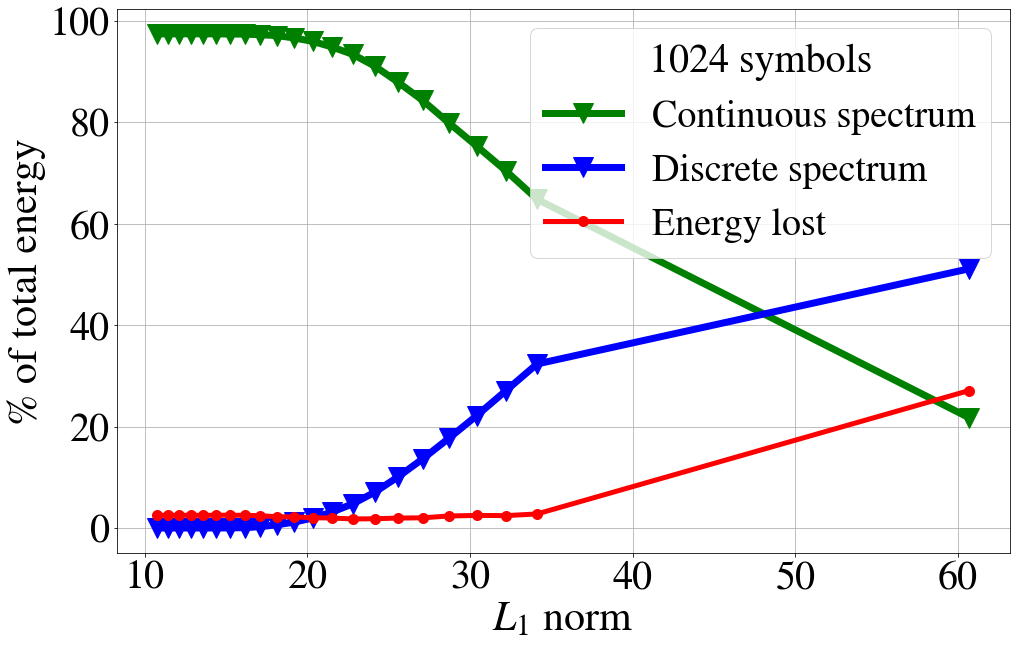

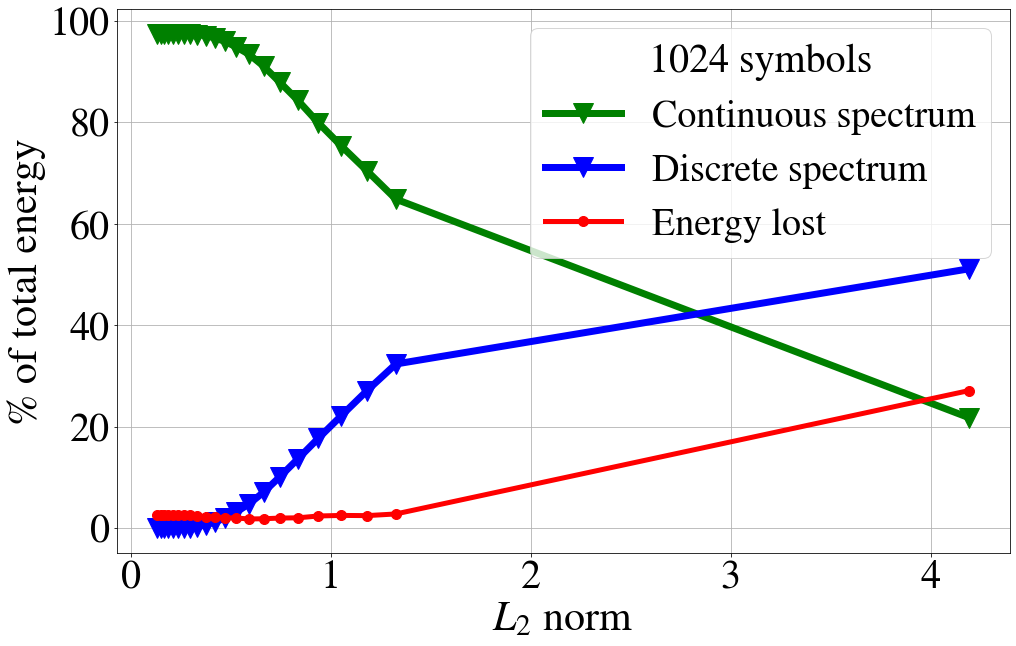

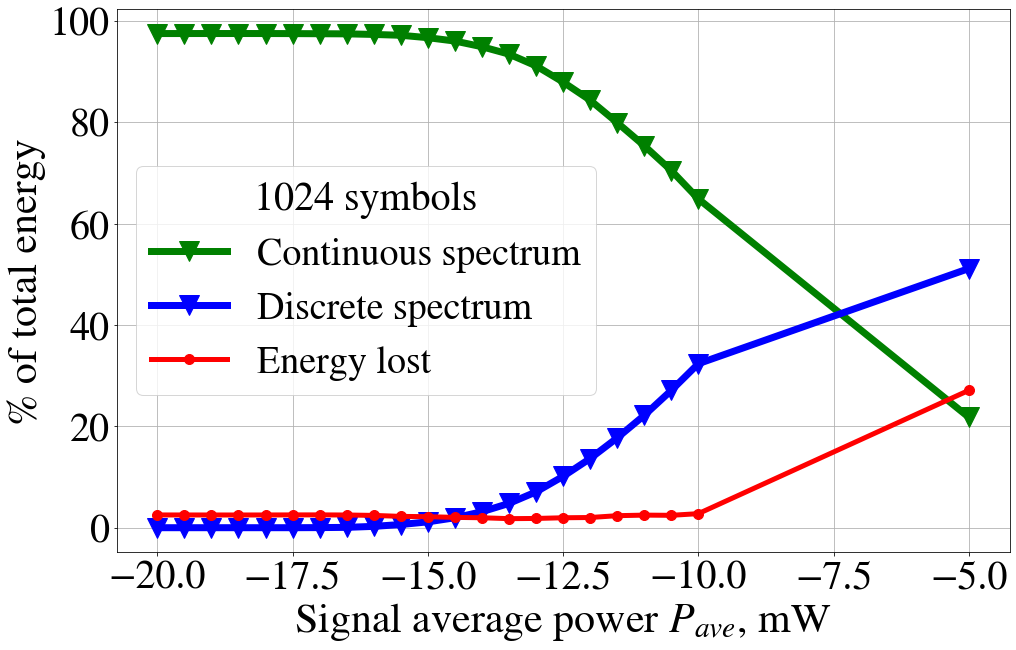

In [154]:
# for i in range(len(num_symbols)):
i = 3

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(np.array(l1_ave[i]), np.absolute(e_ave_cont_p[i]) * 100, color='green',
        label="Continuous spectrum",
        marker='v',
        markersize=20.0,
        linewidth=7.0)
ax.plot(np.array(l1_ave[i]), np.absolute(e_ave_disc_p[i]) * 100, color='blue',
        label="Discrete spectrum",
        marker='v',
        markersize=20.0,
        linewidth=7.0)
ax.plot(np.array(l1_ave[i]), np.absolute(e_ave_diff_p[i]) * 100, color='red',
        label="Energy lost",
        marker='.',
        markersize=20.0,
        linewidth=5.0)
# ax.set_yscale('log')
# ax.set_title('')
# ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(-0.2, 17)
ax.set_ylabel(r'% of total energy', fontsize=42)
ax.set_xlabel(r'$L_1$ norm', fontsize=42)
ax.grid()

plt.legend(title=str(num_symbols[i]) + ' symbols', loc='best', fontsize=38)
# plt.tight_layout()
plt.show()
fig.savefig('images_nft_examples/' + 'ns_' + str(num_symbols[i]) + '_energy_l1.pdf', format='pdf', bbox_inches='tight')


fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(np.array(l2_ave[i]), np.absolute(e_ave_cont_p[i]) * 100, color='green',
        label="Continuous spectrum",
        marker='v',
        markersize=20.0,
        linewidth=7.0)
ax.plot(np.array(l2_ave[i]), np.absolute(e_ave_disc_p[i]) * 100, color='blue',
        label="Discrete spectrum",
        marker='v',
        markersize=20.0,
        linewidth=7.0)
ax.plot(np.array(l2_ave[i]), np.absolute(e_ave_diff_p[i]) * 100, color='red',
        label="Energy lost",
        marker='.',
        markersize=20.0,
        linewidth=5.0)
# ax.set_yscale('log')
# ax.set_title('')
# ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(-0.2, 17)
ax.set_ylabel(r'% of total energy', fontsize=42)
ax.set_xlabel(r'$L_2$ norm', fontsize=42)
ax.grid()

plt.legend(title=str(num_symbols[i]) + ' symbols', loc='best', fontsize=38)
# plt.tight_layout()
plt.show()
fig.savefig('images_nft_examples/' + 'ns_' + str(num_symbols[i]) + '_energy_l2.pdf', format='pdf', bbox_inches='tight')

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(p_dbm_for_graph[i], np.absolute(e_ave_cont_p[i]) * 100, color='green',
        label="Continuous spectrum",
        marker='v',
        markersize=20.0,
        linewidth=7.0)
ax.plot(p_dbm_for_graph[i], np.absolute(e_ave_disc_p[i]) * 100, color='blue',
        label="Discrete spectrum",
        marker='v',
        markersize=20.0,
        linewidth=7.0)
ax.plot(p_dbm_for_graph[i], np.absolute(e_ave_diff_p[i]) * 100, color='red',
        label="Energy lost",
        marker='.',
        markersize=20.0,
        linewidth=5.0)
# ax.set_yscale('log')
# ax.set_title('')
# ax.set_xlim(-21, 5)
# ax.set_ylim(-0.2, 17)
ax.set_ylabel(r'% of total energy', fontsize=42)
ax.set_xlabel(r'Signal average power $P_{ave}$, mW', fontsize=42)
ax.grid()

plt.legend(title=str(num_symbols[i]) + ' symbols', loc='best', fontsize=38)
# plt.tight_layout()
plt.show()
fig.savefig('images_nft_examples/' + 'ns_' + str(num_symbols[i]) + '_energy_power.pdf', format='pdf', bbox_inches='tight')

In [165]:
x_symb = [64, 256, 512, 1024]

# -5 and -10 dBm

e_ave_cont_p_5 = []
e_ave_cont_p_10 = []
e_ave_disc_p_5 = []
e_ave_disc_p_10 = []
e_ave_diff_p_5 = []
e_ave_diff_p_10 = []

v_dbm = -5
for i in range(4):
    # print(p_dbm_for_graph[i])
    i_loc = np.where(np.array(p_dbm_for_graph[i]) == v_dbm)[0]
    # print(i_loc)
    e_ave_cont_p_5.append(np.absolute(e_ave_cont_p[i])[i_loc])
    e_ave_disc_p_5.append(np.absolute(e_ave_disc_p[i])[i_loc])
    e_ave_diff_p_5.append(np.absolute(e_ave_diff_p[i])[i_loc])

v_dbm = -10
for i in range(4):
    i_loc = np.where(np.array(p_dbm_for_graph[i]) == v_dbm)[0]
    e_ave_cont_p_10.append(np.absolute(e_ave_cont_p[i])[i_loc])
    e_ave_disc_p_10.append(np.absolute(e_ave_disc_p[i])[i_loc])
    e_ave_diff_p_10.append(np.absolute(e_ave_diff_p[i])[i_loc])

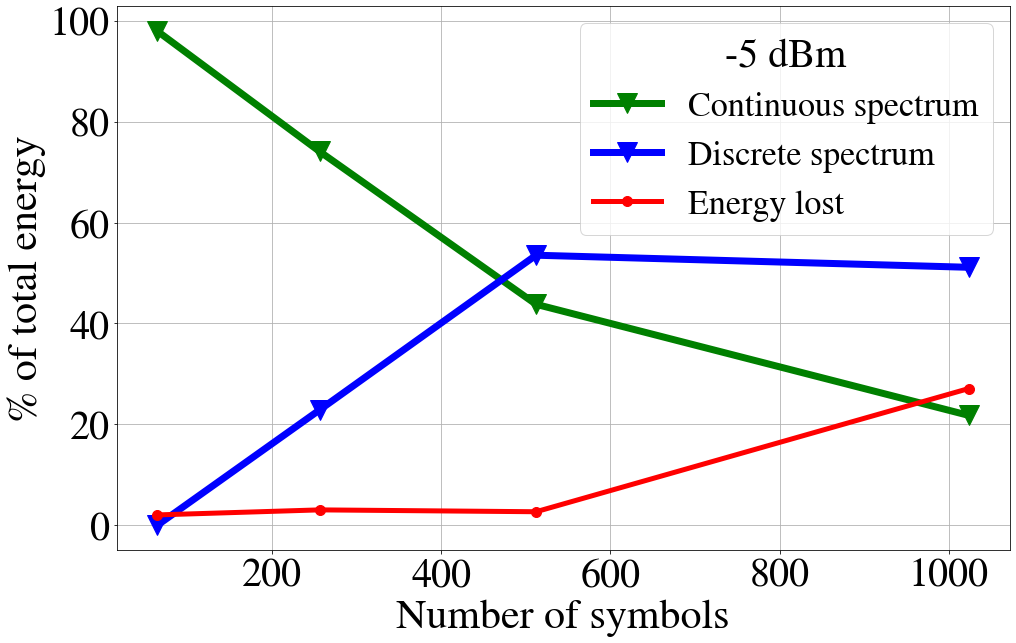

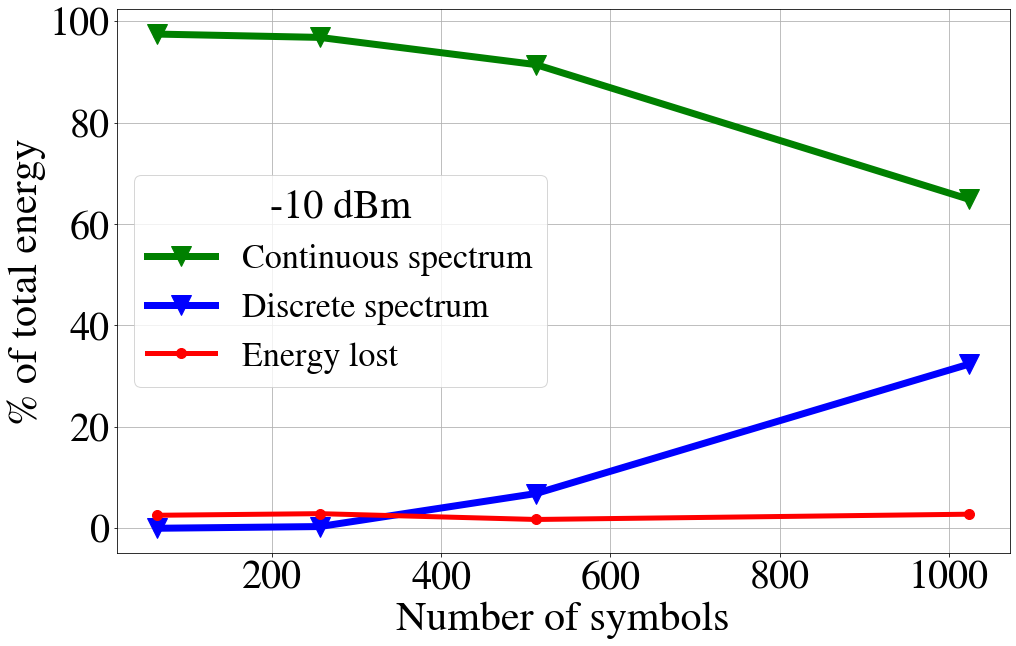

In [171]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(x_symb, np.array(e_ave_cont_p_5) * 100, color='green',
        label="Continuous spectrum",
        marker='v',
        markersize=20.0,
        linewidth=7.0)
ax.plot(x_symb, np.array(e_ave_disc_p_5) * 100, color='blue',
        label="Discrete spectrum",
        marker='v',
        markersize=20.0,
        linewidth=7.0)
ax.plot(x_symb, np.array(e_ave_diff_p_5) * 100, color='red',
        label="Energy lost",
        marker='.',
        markersize=20.0,
        linewidth=5.0)
# ax.set_yscale('log')
# ax.set_title('')
# ax.set_xlim(-21, 5)
# ax.set_ylim(-0.2, 17)
ax.set_ylabel(r'% of total energy', fontsize=42)
ax.set_xlabel(r'Number of symbols', fontsize=42)
ax.grid()

plt.legend(title='-5 dBm', loc='best', fontsize=34)
# plt.tight_layout()
plt.show()
fig.savefig('images_nft_examples/' + 'ns_' + str(num_symbols[i]) + '_m5dbm_energy_symbols.pdf', format='pdf', bbox_inches='tight')

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(x_symb, np.array(e_ave_cont_p_10) * 100, color='green',
        label="Continuous spectrum",
        marker='v',
        markersize=20.0,
        linewidth=7.0)
ax.plot(x_symb, np.array(e_ave_disc_p_10) * 100, color='blue',
        label="Discrete spectrum",
        marker='v',
        markersize=20.0,
        linewidth=7.0)
ax.plot(x_symb, np.array(e_ave_diff_p_10) * 100, color='red',
        label="Energy lost",
        marker='.',
        markersize=20.0,
        linewidth=5.0)
# ax.set_yscale('log')
# ax.set_title('')
# ax.set_xlim(-21, 5)
# ax.set_ylim(-0.2, 17)
ax.set_ylabel(r'% of total energy', fontsize=42)
ax.set_xlabel(r'Number of symbols', fontsize=42)
ax.grid()

plt.legend(title='-10 dBm', loc='best', fontsize=34)
# plt.tight_layout()
plt.show()
fig.savefig('images_nft_examples/' + 'ns_' + str(num_symbols[i]) + '_m10dbm_energy_symbols.pdf', format='pdf', bbox_inches='tight')